## Setup

In [3]:
# Check versions of Keras and Tensorflow
!pip list | egrep 'keras|tensorflow\s|jax\s'

jax                                0.4.33
keras                              3.5.0
keras-core                         0.1.7
keras-cv                           0.9.0
keras-hub                          0.18.1
keras-nlp                          0.18.1
keras-tuner                        1.4.7
tensorflow                         2.17.1
tf_keras                           2.17.0


In [4]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

from IPython.display import display, HTML
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import keras
import keras_cv
import tensorflow as tf
import tensorflow_datasets as tfds
print(f"Keras version: {keras.__version__}, backend: {keras.backend.backend()}")
num_gpus = len(tf.config.list_physical_devices('GPU'))
print(f"GPUs: {num_gpus}")
if num_gpus == 0:
    display(HTML("No GPUs available. Training will be slow. <b>Please enable an accelerator.</b>"))

Keras version: 3.5.0, backend: tensorflow
GPUs: 1


## Train Model

In [13]:
# replace this with your hw1 model!
class config:
    seed = 123
    learning_rate = 1e-3
    epochs = 1
    batch_size = 16
    image_size = (256, 256)
    model_preset = "efficientnetv2_b0_imagenet"
    use_zero_init = True

WEIGHTS_FILENAME = 'hw1.weights.h5'


Homework 1 data loading and model training code goes here. Tip: to avoid retraining each time, you can have code that looks like:

```
if not os.path.exists(WEIGHTS_FILENAME):
    # do your model training here
    # then save:
    model.save_weights(WEIGHTS_FILENAME)
```

In [6]:
#model.save_weights(WEIGHTS_FILENAME)

## Validation and Test Data

In [7]:
data_dir = Path('/kaggle/input/handwritten-letter-classification-25-sp')
!ls {data_dir}

sample_submission.csv  test  test.csv  train  train.csv


In [8]:
valid_df = pd.read_csv(data_dir / 'train.csv').sort_values('filename')
valid_df['label_as_int'] = ['abc'.index(x) for x in valid_df['label']]
test_df = pd.read_csv(data_dir / 'test.csv').sort_values('filename')
valid_df.head()

id  filename label  label_as_int
0     35   035.jpg     c             2
1     36   036.png     a             0
2     69   069.jpg     c             2
3    101  101.jpeg     b             1
50  1017  1017.png     a             0

In [9]:
# Reproducibility: Set a seed so that the results are the same every time this is run.
# See https://keras.io/examples/keras_recipes/reproducibility_recipes/
keras.utils.set_random_seed(config.seed)

### Load the competition data

Docs: https://keras.io/api/data_loading/image/#imagedatasetfromdirectory-function

In [10]:
# Define which classes we want to use, in what order.
class_names = ['a', 'b', 'c']

# Create training and validation datasets
def get_dataset(path, labels_as_ints):
    return keras.utils.image_dataset_from_directory(
        path,
        labels=list(labels_as_ints) if labels_as_ints is not None else None,
        label_mode='int' if labels_as_ints is not None else None,
        batch_size=config.batch_size,
        image_size=config.image_size,
        crop_to_aspect_ratio=True,
        shuffle=False
    )

valid_dataset = get_dataset(data_dir / 'train', valid_df['label_as_int'])
test_dataset = get_dataset(data_dir / 'test', None)

Found 51 files belonging to 3 classes.
Found 982 files.


Let's show some example images.

In [ ]:
[[example_images, example_labels]] = valid_dataset.take(1)
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(np.array(example_images[i]).astype('uint8'))
    label = example_labels[i]
    ax.set(title=f"{label} ({class_names[label]})")
    ax.axis('off')

## Load the model

This code uses the weights saved from above. **Adapt this to load your own model**.

In [12]:
# Create a model using a pretrained backbone
# See https://keras.io/api/keras_cv/models/tasks/image_classifier/ for options
model = keras_cv.models.ImageClassifier.from_preset(
    config.model_preset,
    num_classes=len(class_names))

# Set up the model for training
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=config.learning_rate),
    metrics=['accuracy']
)
model.summary(show_trainable=True)

if Path(WEIGHTS_FILENAME).exists():
    model.load_weights(WEIGHTS_FILENAME)
else:
    print("WARNING: weights file didn't exist, using a random model!")

Model: "image_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer (InputLayer)            │ (None, None, None, 3)        │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ efficient_net_v2b0_backbone         │ (None, None, None, 1280)     │     5,919,312 │    Y    │
│ (EfficientNetV2Backbone)            │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ avg_pool (GlobalAveragePooling2D)   │ (None, 1280)                 │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ predictions (Dense)                 │ (None, 3)                    │         3,843 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 5,923,155 (22.60 MB)

 Trainable params: 5,862,547 (22.36 MB)

 Non-trainable params: 60,608 (236.75 KB)

## Analysis of classifier errors

We'll use the competition's `train` set actually as a *validation* set for diagnosing the classifier's errors. (It's loaded in here as `valid_dataset`.)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
(51, 3)


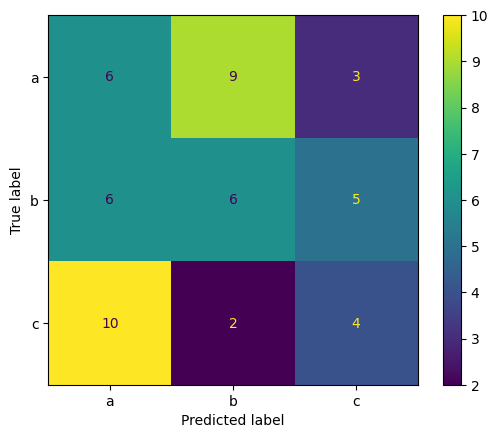

In [16]:
val_predicted_probs = model.predict(valid_dataset)
print(val_predicted_probs.shape)
# Get top prediction
val_predictions = np.argmax(val_predicted_probs, axis=1)

# Extract the correct labels from dataset.
val_labels = [int(label) for img, label in valid_dataset.unbatch()]

# Show the confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(val_labels, val_predictions, display_labels=class_names)


### Make predictions on test set

This code creates a `submission.csv` file with the labels that `model` gives for the test set.

In [17]:
test_predicted_probs = model.predict(test_dataset)
test_predictions = np.argmax(test_predicted_probs, axis=1)
test_df['label'] = [class_names[x] for x in test_predictions]
test_df[['id', 'label']].to_csv('submission.csv', index=False)

62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
